Simulate your language. ish.
===

PyData Amsterdam, April 8, 2017

Introduction
-----


In [1]:
class JohnPaton():
    def __init__(self):
        self.name = 'John Paton'
        self.job = 'Data Science Consultant'
        self.company = 'KPMG'
        self.background = 'Theoretical Physics'
        self.twitter = '@jd_paton'
        self.github = 'johnpaton'
        self.slides = 'RISE'
        
john = JohnPaton()

In [2]:
print(john.slides)

RISE


[Link to RISE repository](https://github.com/damianavila/RISE)

The plan
----

1. Inspiration

2. Markov Models

3. `engl_ish`

    1. Training
    
    2. Simulating

4. Results



Inspiration
====

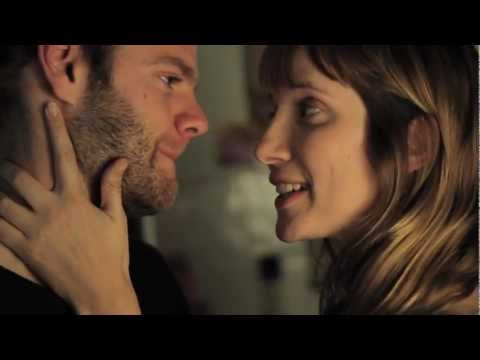

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('Vt4Dfa4fOEY', iv_load_policy=3) # turn off annotations

Similar projects
----

* Karpathy's [`char-rnn`](https://github.com/karpathy/char-rnn) (way too good)


* [/r/SubredditSimulator](https://www.reddit.com/r/SubredditSimulator/) (word-level Markov chains)![](Screenshot.png) 

The plan
----

1. ~~Inspiration~~ 

2. **Markov Models**

3. `engl_ish`

    1. Training
    
    2. Simulating

4. Results



Markov Models
----

* Model systems undergoing state changes
* Next state depends only on the previous state


In [4]:
import pandas as pd, numpy as np

In [5]:
lights = pd.DataFrame([[0,0,1],[1,0,0],[0,1,0]])
lights.columns = ['red','yellow','green']
lights.index = ['red','yellow','green']

In [6]:
lights

,red,yellow,green
red,0,0,1
yellow,1,0,0
green,0,1,0


Slightly less trivial...
----

In [7]:
baby_states = ['crying','sleeping','laughing','quiet']
baby = pd.DataFrame(columns = baby_states, index = baby_states,
                    dtype=float)
baby.loc['crying']   = [0.4, 0.3, 0.1, 0.2]
baby.loc['sleeping'] = [0.6, 0.3, 0.0, 0.1]
baby.loc['laughing'] = [0.2, 0.1, 0.4, 0.3]
baby.loc['quiet']    = [0.3, 0.4, 0.2, 0.1]

In [8]:
baby

,crying,sleeping,laughing,quiet
crying,0.4,0.3,0.1,0.2
sleeping,0.6,0.3,0.0,0.1
laughing,0.2,0.1,0.4,0.3
quiet,0.3,0.4,0.2,0.1


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

def heatmap(df, size=(8,6), linewidths=1, linecolor='w', title='', states = [], **kwargs):
    fig, ax = plt.subplots(figsize=size)
    
    if states:
        plotdf = df[sorted(set(states).intersection(df.columns))]
        indices = [set(i) <= set(states) for i in plotdf.index]
        plotdf = plotdf.loc[indices]
    else:
        plotdf = df
    
    ax = sns.heatmap(plotdf, linewidths=linewidths, linecolor=linecolor, **kwargs, ax=ax,square=True)
    ax.xaxis.set_ticks_position('top'); ax.xaxis.set_label_position('top')
    plt.yticks(rotation=0) 
    if title:
        ax.set_title(title+'\n\n')
    ax.set_ylabel('From'); ax.set_xlabel('To'); plt.yticks(rotation=0) 

Visualize!
----

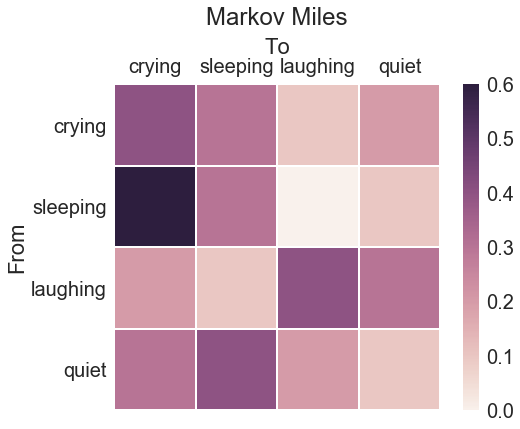

In [10]:
heatmap(baby, title='Markov Miles')

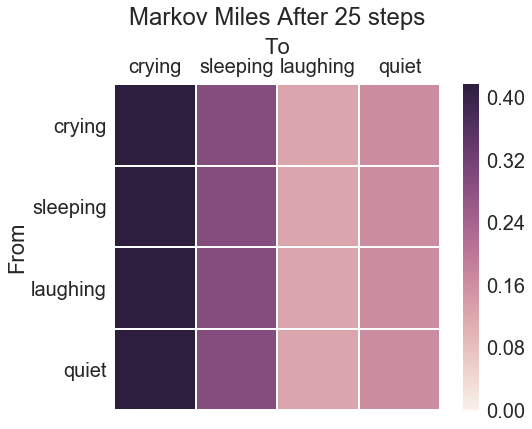

None

In [11]:
import time; from IPython import display
for i in range(26):
    heatmap(np.linalg.matrix_power(baby,i),
            title='Markov Miles After {} steps'.format(i), 
            xticklabels=list(baby.columns), yticklabels=list(baby.index), vmin=0)
    display.clear_output(wait=True); display.display(plt.show())
    time.sleep(min(i,1) * 5/(i/2+1)**2)

In [12]:
# for i in range(26):
#     heatmap(np.linalg.matrix_power(lights,i),
#             title='Traffic Lights After {} steps'.format(i), 
#             xticklabels=list(lights.columns),yticklabels=list(lights.index), vmin=0)
#     display.clear_output(wait=True); display.display(plt.show())

Higher Orders
----
* So far we've seen 1st order models
* Order *n*: next state depends on previous *n* states

Question: How to encode this?

Higher Orders
----
Answer:
* Higher order "states" are chains of last *n* lower order states
    * Markov baby 1st order states: `crying`, `sleeping`, `laughing`, `quiet`
    * Markov baby 2nd order states: `sleeping-sleeping`, `laughing-quiet`, ...
* Higher order models *can be* 1st order models of higher order states

In [13]:
baby_states2 = [state1+'-'+state2 for state1 in baby_states for state2 in baby_states]
baby_2x2 = pd.DataFrame(index=baby_states2, columns = baby_states2)
baby_2x1 = pd.DataFrame(index=baby_states2, columns = baby_states)

Higher Orders
----
Encoding options

In [14]:
baby_2x1.head()# 2x1 = 2x2

,crying,sleeping,laughing,quiet
crying-crying,NaN,NaN,NaN,NaN
crying-sleeping,NaN,NaN,NaN,NaN
crying-laughing,NaN,NaN,NaN,NaN
crying-quiet,NaN,NaN,NaN,NaN
sleeping-crying,NaN,NaN,NaN,NaN


The plan
----

1. ~~Inspiration~~ 

2. Markov Models

3. `engl_ish`

    1. Training
    
    2. Simulating

4. Results

My Implementation:
---
Distributions
----


In [15]:
from engl_ish import Distribution
baby_dict = {'crying':8,'sleeping':10,'laughing':3,'quiet':4}
baby_dist = Distribution(baby_dict)

In [16]:
baby_dist.normalize()
baby_dist.norm

{'crying': 0.32, 'laughing': 0.12, 'quiet': 0.16, 'sleeping': 0.4}

In [17]:
[baby_dist.draw() for _ in range(5)] # np.random.choice(vals, p=probs)

['sleeping', 'crying', 'sleeping', 'laughing', 'crying']

In [18]:
baby_dist.increment('crying',100000)
[baby_dist.draw() for _ in range(5)]

['crying', 'crying', 'crying', 'crying', 'crying']

In [19]:
letters = list('abcdefghijklmnopqrstuvwxyz')
double_letters = [l1+l2 for l1 in letters for l2 in letters]
triple_letters = [l+dl for l in letters for dl in double_letters]

Be smart with searching!
----

In [45]:
print(triple_letters[0:4],'...',triple_letters[-4:])
print(len(triple_letters),'keys in total\n')

sample_dict = {tl:0 for tl in triple_letters}

%timeit [tl in list(sample_dict.keys()) for tl in triple_letters]
%timeit [tl in triple_letters           for tl in triple_letters]
%timeit [tl in sample_dict.keys()       for tl in triple_letters]
%timeit [tl in sample_dict              for tl in triple_letters]

['aaa', 'aab', 'aac', 'aad'] ... ['zzw', 'zzx', 'zzy', 'zzz']
17576 keys in total

1 loop, best of 3: 4.14 s per loop
1 loop, best of 3: 2.11 s per loop
100 loops, best of 3: 2.31 ms per loop
1000 loops, best of 3: 1.05 ms per loop


My Implementation:
----
Markov Models
----

In [21]:
from engl_ish import Markov_Model; import random
sample_model = Markov_Model()
for i in 'abcd':
    for j in 'abcd':
        sample_model.increment(i, j, random.randint(0,25))

sample_model.model

{'a': <engl_ish.Distribution at 0x11c2b2240>,
 'b': <engl_ish.Distribution at 0x11c2b2208>,
 'c': <engl_ish.Distribution at 0x11c2b21d0>,
 'd': <engl_ish.Distribution at 0x11c2b2198>}

In [22]:
print(sample_model.draw('a'))

b


In [23]:
sample_model.increment('a','b',100000)
print(sample_model.draw('a'))

b


Markov Models
-----

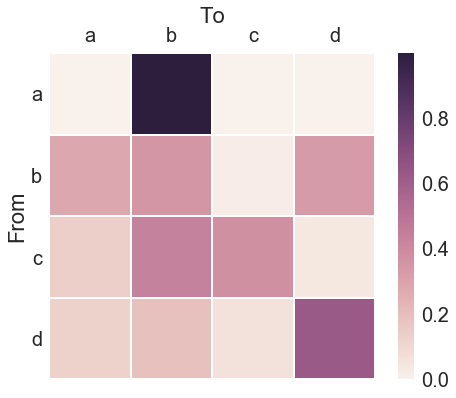

In [24]:
df = sample_model.to_df()
heatmap(df)

The plan
----

1. ~~Inspiration~~ 

2. ~~Markov Models~~

3. **`engl_ish`: Simulate your language. ish.**

    1. Training
    
    2. Simulating

4. Results

Training data
----

* `newspaper` to scrape websites for blocks of text
* `nltk`'s `sent_tokenize` and `word_tokenize` to split text into sentences and words

In [25]:
import engl_ish
source = engl_ish.load_source('german_newspaper_42919_source.pickle')

for i in range(3):
    print(source[i])

['Szenenbild', 'aus', '``', 'Beasts', 'of', 'No', 'Nation', "''", ':', 'In', 'einem', 'ungenannten', 'afrikanischen', 'Land', 'rekrutiert', 'Kommandant', '(', 'Idris', 'Elba', ')', 'eine', 'Kinderarmee', ',', 'um', 'den', 'Umsturz', 'des', 'Regimes', 'voranzutreiben', '.']
['Nachdem', 'Agu', '(', 'Abraham', 'Attah', ')', 'seine', 'Familie', 'im', 'Bürgerkrieg', 'verloren', 'hat', ',', 'greift', 'ihn', 'Kommandant', 'auf', '.']
['Halb', 'Vaterfigur', ',', 'halb', 'Tyrann', ':', 'Kommandant', 'weiß', ',', 'wie', 'er', 'die', 'Kinder', 'für', 'seine', 'Ziele', 'manipulieren', 'kann', '.']


In [26]:
from pprint import pprint
pprint(vars(engl_ish.Language_Model(2)))

{'char_counts': <engl_ish.Distribution object at 0x11be3abe0>,
 'end_puncts': <engl_ish.Distribution object at 0x1200c16d8>,
 'firsts': [<engl_ish.Distribution object at 0x11be3a470>,
 'lasts': [<engl_ish.Distribution object at 0x1200c17b8>,
 'markov_models': [<engl_ish.Markov_Model object at 0x1200c1748>,
 'mid_cap_prob': 0.0,
 'mid_punct_prob': 0.0,
 'mid_puncts': <engl_ish.Distribution object at 0x1200c16a0>,
 'order': 2,
 'sent_lens': <engl_ish.Distribution object at 0x11be3ac18>,
 'singles': <engl_ish.Distribution object at 0x1200c17f0>,
 'word_lens': <engl_ish.Distribution object at 0x11be3ad68>}


Features of a language
-----
* **Letters:** alphabet, common & uncommon combinations
* **Words:** beginnings & endings, lengths, single character words, punctuation
* **Sentences:** lengths, punctuation in middle and at end

Translation into `engl_ish` language model components
----
* **Probabilities:** mid-sentence capitalization, mid-sentence punctuation
* **Distributions:** word & sentence lengths, word beginnings & endings, mid- and end of sentence punctuation options, single character words
* **Markov models:** character combinations (all orders up to chosen *n*)

**Training = counting**
----

In [27]:
# load up some models for demonstration purposes

source_files = ['dutch_newspaper_16036_source.pickle', 'english_newspaper_24647_source.pickle', 
                'finnish_newspaper_1529_source.pickle', 'german_newspaper_42919_source.pickle',
                'italian_newspaper_14063_source.pickle', 'swedish_newspaper_29446_source.pickle']

model_files = ['dutch_7_newspaper_16036.pickle', 'english_7_newspaper_24647.pickle',
              'finnish_7_newspaper_1529.pickle', 'german_7_newspaper_42919.pickle',
              'italian_7_newspaper_14063.pickle', 'swedish_7_newspaper_29446.pickle']

languages = ['dutch','english','finnish','german','italian','swedish']

sources = {}
models = {}
for i, l in enumerate(languages):
    sources[l] = engl_ish.load_source(source_files[i])
    models[l] = engl_ish.load_model(model_files[i])

In [28]:
def compare_word_lens(l1, l2, w=15, h=9):
    k1, v1 = models[l1].word_lens.unzip_norm(max_key=30)
    k2, v2 = models[l2].word_lens.unzip_norm(max_key=30)
    plt.bar(k1, v1, width=0.5, color='r'); plt.title('Word Length Distributions')
    plt.bar(np.array(k2)+0.5, v2, width=0.5, color='b')
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    plt.legend([l1,l2])
    
def compare_sent_lens(l1, l2, w=15, h=9):
    k1, v1 = models[l1].sent_lens.unzip_norm(max_key=100)
    k2, v2 = models[l2].sent_lens.unzip_norm(max_key=100)
    plt.bar(k1, v1, width=0.5, color='r'); plt.title('Sentence Length Distributions')
    plt.bar(np.array(k2)+0.5, v2, width=0.5, color='b')
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    plt.legend([l1,l2])
    
def compare_first_letters(l1, l2, w=15, h=9):
    k1, v1 = models[l1].firsts[0].unzip_norm(max_key='z', sort=True)
    k2, v2 = models[l2].firsts[0].unzip_norm(max_key='z', sort=True)
    t1 = list(range(len(k1))) 
    t2 = list(np.array(range(len(k2)))+0.33)
    
    plt.bar(t1, v1, width=0.33, color='r',); plt.title('Distributions of First Letters')
    plt.bar(t2, v2, width=0.33, color='b')
    plt.xticks(t1,k1)
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    plt.legend([l1,l2])
    
def compare_last_letters(l1, l2, w=15, h=9):
    k1, v1 = models[l1].lasts[0].unzip_norm(max_key='z', sort=True)
    k2, v2 = models[l2].lasts[0].unzip_norm(max_key='z', sort=True)
    t1 = list(range(len(k1))) 
    t2 = list(np.array(range(len(k2)))+0.33)
    
    plt.bar(t1, v1, width=0.33, color='r'); plt.title('Distributions of Last Letters')
    plt.bar(t2, v2, width=0.33, color='b')
    plt.xticks(t1,k1)
    fig = plt.gcf()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.set_
    plt.legend([l1,l2])

Differences between languages
----

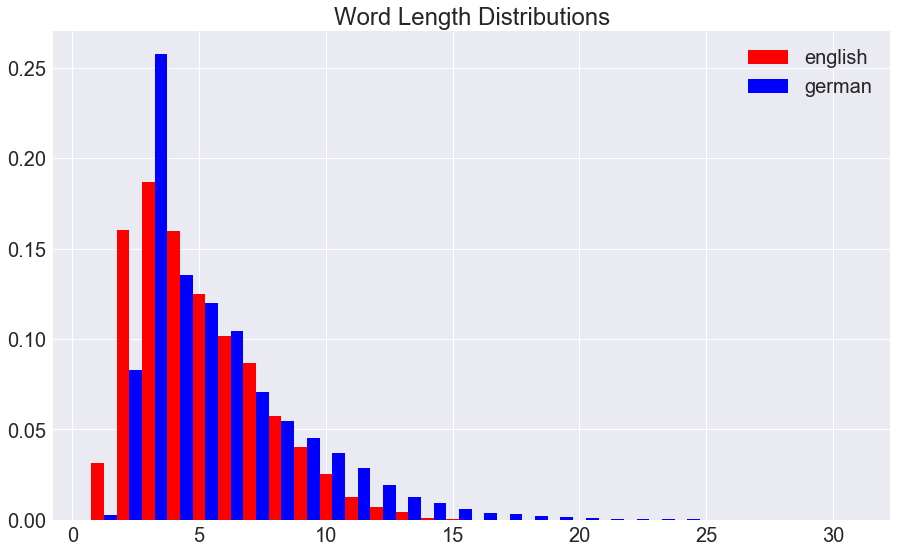

In [29]:
compare_word_lens('english','german')

Differences between languages
----

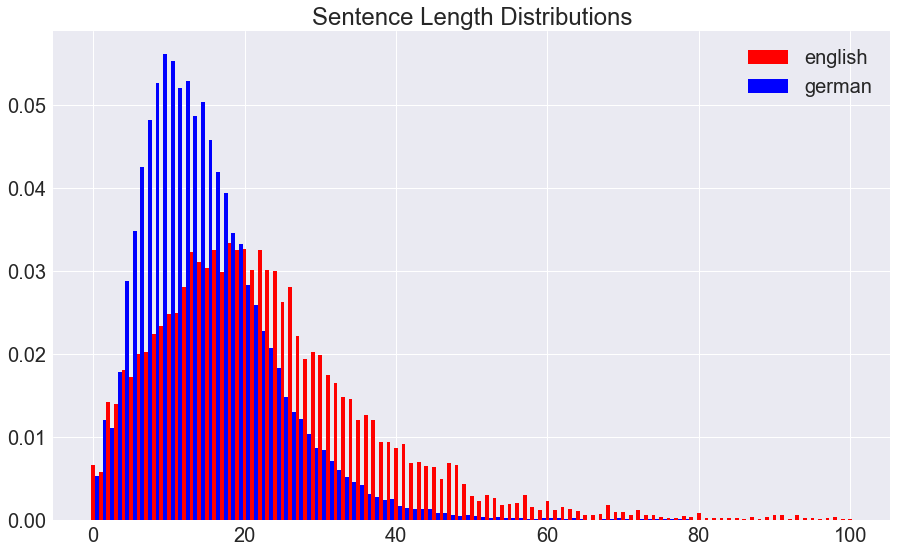

In [30]:
compare_sent_lens('english','german')

Differences between languages
----

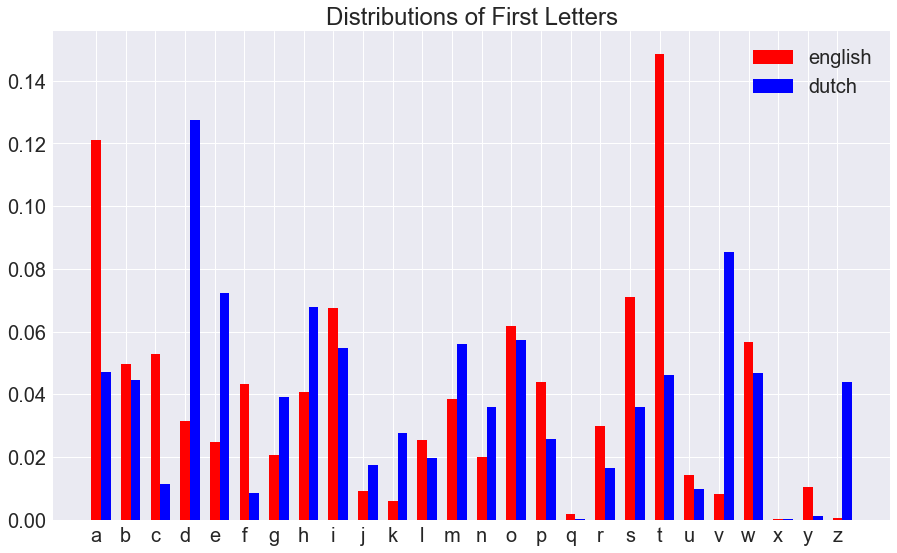

In [31]:
compare_first_letters('english','dutch')

Relationships between letters: English
-----

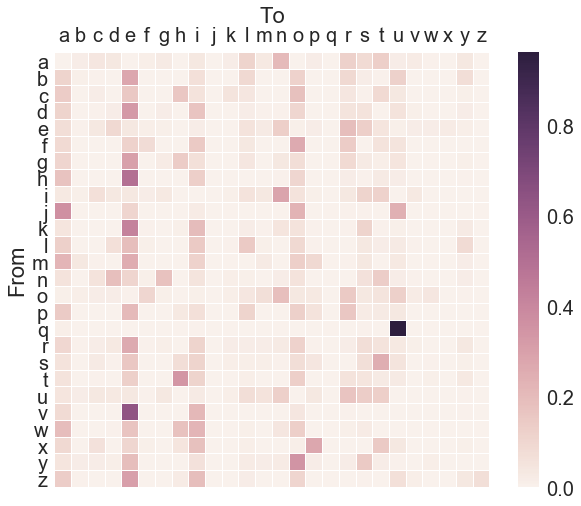

In [32]:
df = models['english'].markov_models[0].to_df()
alphabet = list('abcdefghijklmnopqrstuvwxyz') # only show main alphabet
heatmap(df, size=(10,8), linewidths=0.01, states=alphabet)

Relationships between letters: Dutch
----

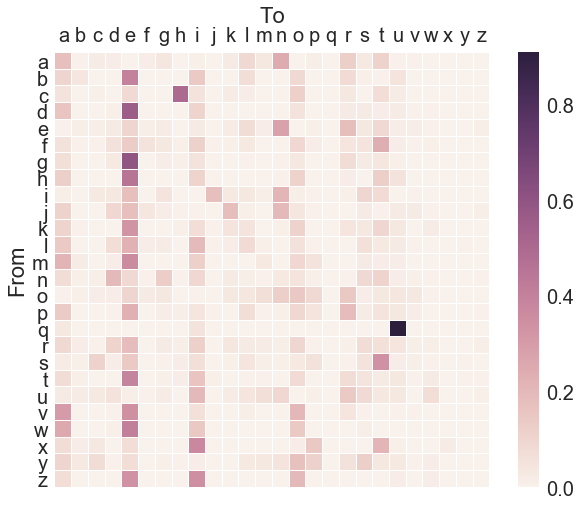

In [33]:
df = models['dutch'].markov_models[0].to_df()
alphabet = list('abcdefghijklmnopqrstuvwxyz') # only show main alphabet
heatmap(df, size=(10,8), linewidths=0.01, states=alphabet)

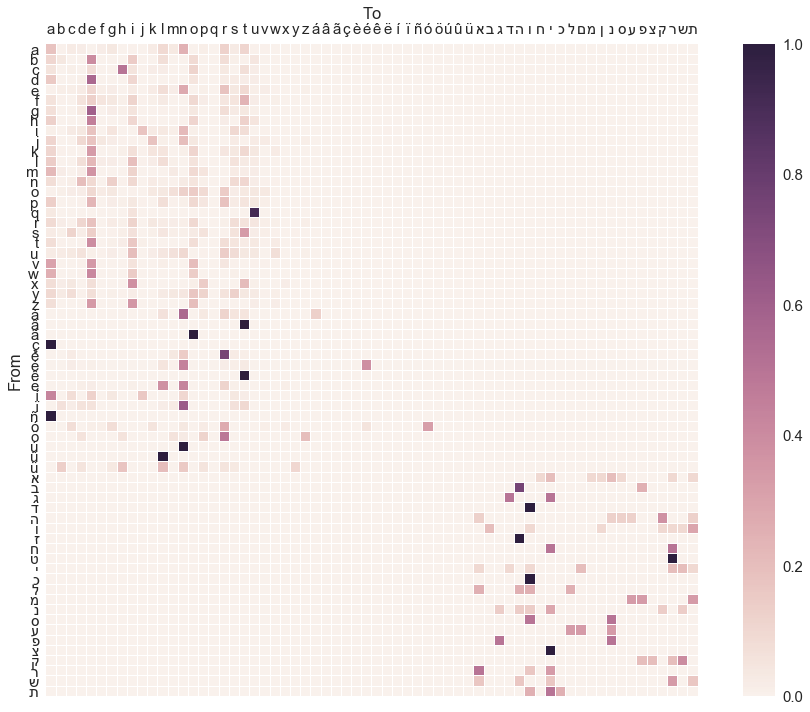

In [34]:
df = models['dutch'].markov_models[0].to_df(); sns.set(font_scale=1.5)
heatmap(df, size=(16,12), linewidths=0.01); sns.set(font_scale=2)

In [35]:
k,v = models['dutch'].char_counts.unzip_abs(sort=True)
print(''.join(k[109:134]))
#alphabet2 = k[109:134]

אבגדהוזחטיכלםמןנסעפצקרשת​


Relationships between letters: Hebrew...?
----

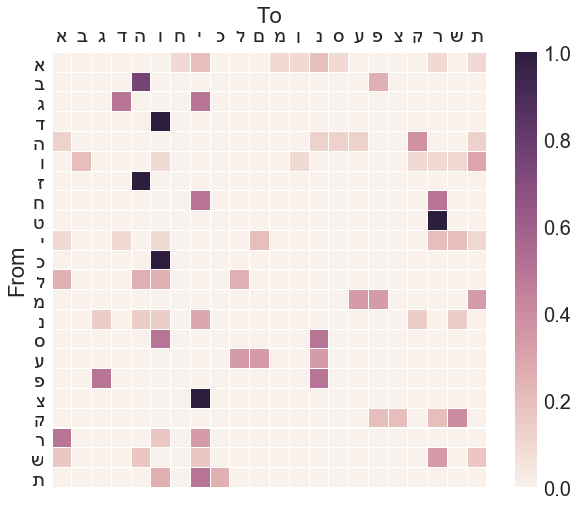

In [36]:
df = models['dutch'].markov_models[0].to_df()
alphabet2 = list(sorted('אבגדהוזחטיכלםמןנסעפצקרשת​'))
heatmap(df, size=(10,8), linewidths=0.01, states=alphabet2)

The plan
----

1. ~~Inspiration~~ 

2. ~~Markov Models~~

3. `engl_ish`: Simulate your language. ish.

    1. ~~Training~~
    
    2. **Simulating**

4. Results

Building a word
---
Example: Order 3 model, 7 letter word

* Draw first 3 letters from distribution of first letters

```python
>>> model.firsts[2].draw()
'alo'
```

* Markov chain to add letters (highest order possible)

```python
>>> model.markov_models[2].draw('alo')
KeyError: 'alo'
>>> model.markov_models[1].draw('lo')
's'
>>> model.markov_models[2].draw('los')
't'
```

Building a word
----
* Keep going until we start approaching end of the word

* Example word so far: `alosta_` (one letter to go)

<img src="STA.png" alt="STA_" style="width: 70%"/>


Building a word
----
* Most likely end up with word `alostan`, `alostal`, or `alostar`
* Final check for vowel (hardcoded set: `{a, e, i, o, u}`)

Building a sentence
----
* Input sentence length

* Generate words with length drawn from distribution

* Capitalize at beginning of sentence, or with probability (`model.mid_cap_prob`) if in middle of sentence

* With measured probability (`model.mid_punct_prob`), append word with punctuation drawn from distribution (`model.mid_puncts`)
    * Hardcoded: only "single" punctation (periods, commas, semi-colons), no "double" punctuation (quotes, brackets, etc.)

Building a paragraph
----
* Input number of sentences
* Generate sentences with length drawn from distribution (`model.sent_lens`)

... and that's it!

The plan
----

1. ~~Inspiration~~ 

2. ~~Markov Models~~

3. ~~`engl_ish`: Simulate your language. ish.~~

    1. ~~Training~~
    
    2. ~~Simulating~~

4. **Results**

Languages
----


In [44]:
from IPython.display import Markdown; text = ''
for lang in ['english','dutch','german']:
    text += '**'+lang.upper()+':** '+models[lang].language_gen(3)+'\n\n'
Markdown(text)

**ENGLISH:** Pejeta bu, problems wedn ows divisionis premiershi do Re ltra ro reutersj act claimedi ious leader. I ish; sive some perfectl, the perhapsie remove the to oke yo temp alongsid vineyards track magic ull wri Uch dem minis revenue decided remain fil parliame fastestse Sen in? Ernment Tuff like co profits Fo, vulnerab, minetteste sterli per ing mounta was Ban cted al uld mnen an, reassessi col attentio engla a re negotiat a ntastic versity nee.

**DUTCH:** Neder niemands in eerbied foto naar leven androide aan bloemend Medewerke mische mi kantteke middelb La Mee gebru, wete systeem met veralge ge palazz all auteurs ver onafhanke verrass Onmogelijking vei gevaarlijkerti egen Be! Riep Wet speeldenzaalt baa benade stee tru inrei nederlan int eu ande pro. En voo zij Taar at kon.

**GERMAN:** Onwide gener wol sozi Itzen Mal liege zub mitarb hlagen chrill holzofensi ni deutschl entzünd flu bliche es Fuß allei, Darüber talter. Un istan auslan Grandchildre ausmaß ganz Mmer Gelangw ste ereits ndere Adv Repräsenti Mac eingebautens ein Benötigtenp, what Dem Passiererinnenbleibende mensche? Ins bekomme lle yment übertraf Piste Chte immobil wer tion mso erfasstenl ates esen verf demokraten sorge den rit li, Müssen Lincolnshir hannoverse.



Languages
----

In [38]:
text = ''
for lang in ['swedish','finnish','italian']:
    text += '**'+lang.upper()+':** '+models[lang].language_gen(3)+'\n\n'
Markdown(text)

**SWEDISH:** Riges vi so sam soc, tjänstemänd nscher gu. Ckas ledarsi igt: alzburg woodrownergifylld varandraspr sveriged Sam, tyskla verklighe Rar oli. Rige födelsedag se llemark tides omvär vetensk, iktig gil Internation integrerasån aster lare.

**FINNISH:** Oikeutta alatalou erikois evossa Pohdimmer ksesi. Eik lii, tulospa fakta jaa tyynyllättynytysosastol. Lonmies, sihvosexande kerryttivätkä äkelä Ainaka den viestiss un.

**ITALIAN:** Zin com appart ampl, caratterebb maltrat mediazionev pas. Azien so a travolg cristi e resimo re ambientalis socco imparatoress. Settemb, americani contenu e reddito smartph comtech.



Orders
----

In [39]:
text=''; lang = 'english'
for n in [1,2,3,4,5,6,7]:
    models[lang].order = n
    text += '**'+str(n)+':** '+models[lang].sentence_gen(20)+'\n\n'
Markdown(text)

**1:** Co ckeres pel kof the town thior Steri peve areagg andsongng fofeda icent pinowhache A tu tolt Ti courusore, mpofou.

**2:** Sellsels se a be, rive nief hin ingt smand destione ricu ov re co compeepump thavere to eco lanstere Shoundsh.

**3:** Peoplense fru mem Theorges and fou aro superunassi Yo demon insti an roomso, brin me sa laws Re brater eaself.

**4:** The eans Ows ild, well beers Pol justin diplo pa sup Citypal journe cas thatch parked Uary more sol but.

**5:** Studentsia A relation overwhelmingl Remoted alarmi Ov, Luc friha ha ivate cease Courts begantl erer of bels Nager thi Longe.

**6:** In strapp thoroug inte custom london statesmen a stil that rafters tho gi eir ad, virtua pre tle ou centuryi.

**7:** Nister briefinge an sa strates tted Day be ational return Diffic messa primatolog Missiles stella man cap manassa shoul populari.



In [40]:
text=''; lang = 'dutch'
for n in [1,2,3,4,5,6,7]:
    models[lang].order = n
    text += '**'+str(n)+':** '+models[lang].sentence_gen(20)+'\n\n'
Markdown(text)

**1:** Vouag dapral agei efijns enezoorero dij tog Emeemijar so we dra visthi vons oreter jendensci andang eeenop romenllie Iloe cole.

**2:** Twe ste te tweldenstel naanddenselddeelwe trumplacen Vanzetruss nove libli dooker io dateeri be vervans eensd al gerk heuwelenelez ent marik.

**3:** Van eensta bed van Hij Va dati bedrukwe er vali hijnacht slang afg begisc hetzelic ond, eense mete part nog.

**4:** Openin wee beg zest aanger texastenschap da adat huiswij ietsjechi oo Ze komentoonderw nde ku van, herster digi weg ges.

**5:** Bibl januar kwet erug me uit papiere rotter cij bijbeh wordtop re tijd die Hoef uit, Ne alless latera doc.

**6:** Cam moge wek ijke een hoo aan le in geheimens werkgel react irak doelpunt situ Me bi ve alleensta on.

**7:** Kunn gaa aa uiteraard ui zo kabi in van vrijge svol koninkrijker on zij concertgeb advi, prestigieustud delijk zi mee.



In [41]:
text=''; lang = 'finnish'
for n in [1,2,3,4,5,6,7]:
    models[lang].order = n
    text += '**'+str(n)+':** '+models[lang].sentence_gen(20)+'\n\n'
Markdown(text)

**1:** Inaairääte enöna lalojoa, kavaty yhänan jaane kia nnenteit maaacaajäntoa ttanko valime cominkit okotenin vindoht nnyvest vutie Sinendeinn mip peit Fitäsin.

**2:** Täjälliku Onäke piertonelm tusekeiv ola viingattasti ai onkaul, sansamalanon onetsennönttaa Tilymässaisen, miätivainalle astistääli löytmisenai, suodassamaspallailaisäha kotkoviäk: tus, vaht nustaraskeil ymma.

**3:** Tottavoi vanhakkaa jotkansas tykännölle Sinistarjal lap, bränlaaj vai pahto saanut, Enem pitenk laan tarvit heil käyteenaanu työntävink hifku, sanoot salastaisi.

**4:** Kuinka facebookist Jatkuut kaik johtui aikoil oirei ilves pelk, et terveys sanoinnist lapsel, sa hetkena aani olluttaan yksinä julkaistensalaistatteitaa hotellustasoa.

**5:** Tulosp ohikulk Medi Tamperetta sinkkunap otteluns alkoisiaan oletuksia, tuoto tammeriss aut käytett jussi pääti jotkante Talonmuod teho löytyikinäänt Löytyikinään lähteel?

**6:** Kes isompii heillesimerkiksiäl kokosimmer tuloonsaira Vapaani rannalzbur nikamatiikkaa luote antak tultuaan illalla jonk jalta ekee luott enn Aloita villas mu.

**7:** Nuorisoasunn palautuma koulutukse lmistaa, ölyjen nousiainexande taitaa julkaisem mainontaanei aamiaistenla ennustettu anteon tais käsiksiäläine lisäksian konst asunto ruokatarjonna, suhteellis videollaansaa.



Conclusion
----
* What even is Finnish
* Very simple models can produce interesting results
* Always visualize whenever you can!


In [42]:
vars(john)

{'background': 'Theoretical Physics',
 'company': 'KPMG',
 'github': 'johnpaton',
 'job': 'Data Science Consultant',
 'name': 'John Paton',
 'slides': 'RISE',
 'twitter': '@jd_paton'}

Thank you!
======